# Cегментация клиентов банка

Датасет взят с kaggle (https://www.kaggle.com/datasets/uciml/german-credit/code?datasetId=531). В нем представлена информация о клиентах банка, которые обращаются за кредитом. Целью данной работы является построение различных вариантов кластеризаций клиентов банка и интерпретация результатов.

## 1. Изучение данных

### Описание данных

* **Age** - возраст
* **Sex** - пол (text: male, female)
* **Job** - работа (квалифицированный/неквалифицированный, резидент/нерезидент)
* **Housing** - жилье(собственность, аренда, нет) 
* **Saving accounts** - сберегательные счета 
* **Checking account** -  текущий счет
* **Credit amount** - сумма кредита 
* **Duration** - продолжительность (в месяцах)
* **Purpose** - цель кредита 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [78]:
data = pd.read_csv('archive.zip', compression='zip')
print(data.shape)
data.head()

(1000, 10)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [79]:
# уберем лишний столбец "Unnamed: 0"
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [81]:
data= data.fillna('unknown')

Создадим датасет, в который входят только численные признаки

In [6]:
num_col = [col for col in data.columns if data[col].dtype != 'object']

In [7]:
data_num = data[num_col]

Посмотрим как распределены значения категориальных признаков

In [8]:
cat_col = [col for col in data.columns if data[col].dtype == 'object']
cat_col

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [9]:
for col in cat_col:
    print(col)
    print(data[col].value_counts())
    print('─' * 10)

Sex
male      690
female    310
Name: Sex, dtype: int64
──────────
Housing
own     713
rent    179
free    108
Name: Housing, dtype: int64
──────────
Saving accounts
little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
──────────
Checking account
unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
──────────
Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
──────────


In [10]:
#закодируем категориальные переменные с помощью LabelEncoder
label_encoder = LabelEncoder()
for col in cat_col:
        data_num[col] = label_encoder.fit_transform(data[col])

In [11]:
data_num.head()

,Age,Job,Credit amount,Duration,Sex,Housing,Saving accounts,Checking account,Purpose
0,67,2,1169,6,1,1,4,0,5
1,22,2,5951,48,0,1,0,1,5
2,49,1,2096,12,1,1,0,3,3
3,45,2,7882,42,1,0,0,0,4
4,53,2,4870,24,1,0,0,0,1


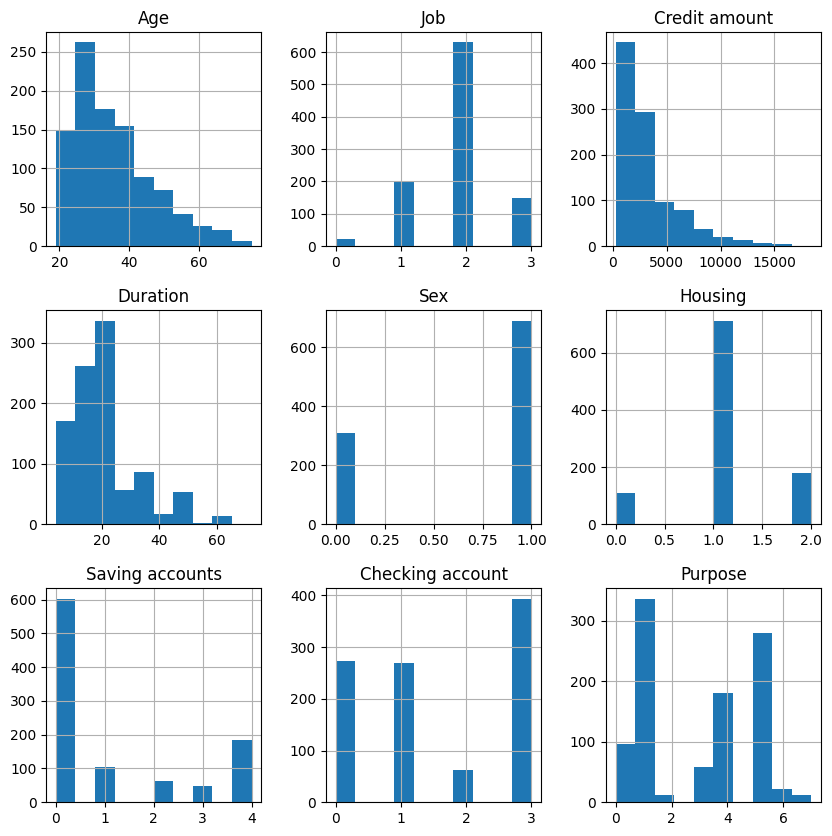

In [12]:
# посмотрим на распределние признаков
data_num.hist(figsize=(10,10));

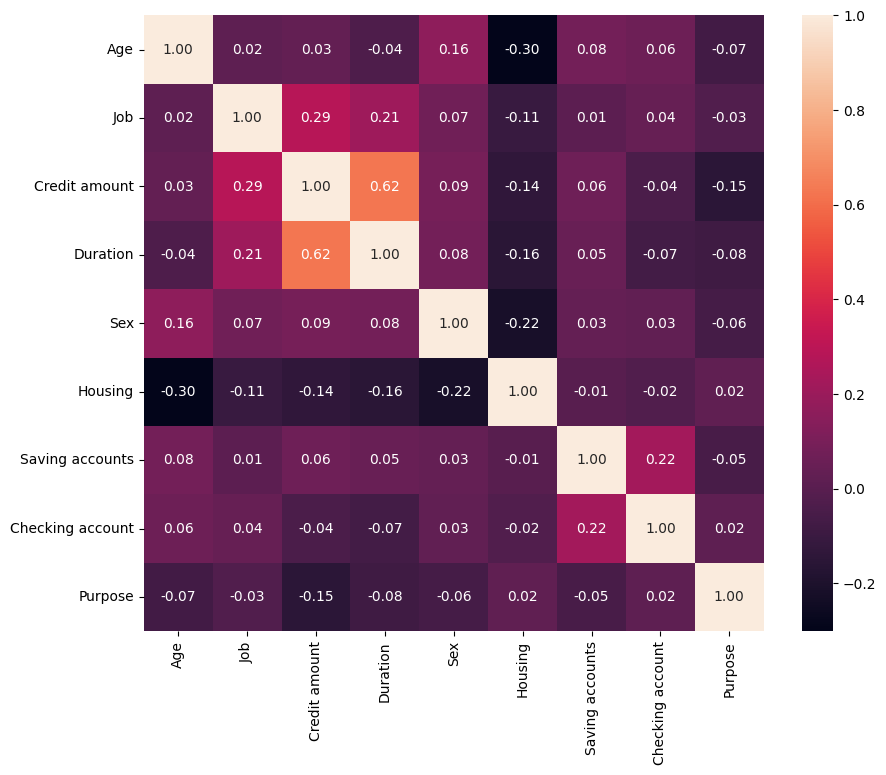

In [13]:
# посмотрим на корреляцию признаков
corr = data_num.corr()
plt.figure(figsize=(10,8));
sns.heatmap(corr, annot=True, fmt='.2f');

В основном между признаками довольно слабая корреляция. Ниаболее зависимы друг с другом признаки суммы и срока кредита.

Поскольку алгоритм k-means считает расстояния до точек, нам важно, чтобы данные были в одинаковом масштабе. Воспользуемся для этого StandardScaler().

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_num)
data_scaled = pd.DataFrame(X_scaled, columns=data.columns)
data_scaled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,2.766456,0.146949,-0.745131,-1.236478,0.670280,-0.133710,1.833169,-1.254566,1.073263
1,-1.191404,0.146949,0.949817,2.248194,-1.491914,-0.133710,-0.699707,-0.459026,1.073263
2,1.183312,-1.383771,-0.416562,-0.738668,0.670280,-0.133710,-0.699707,1.132053,0.061705
3,0.831502,0.146949,1.634247,1.750384,0.670280,-2.016956,-0.699707,-1.254566,0.567484
4,1.535122,0.146949,0.566664,0.256953,0.670280,-2.016956,-0.699707,-1.254566,-0.949853


## 2. Моделирование

### 2.1 Снижение размерности

Применим методы снижения размерности для визуализации данных

### PCA

In [15]:
pca = PCA()
pca.fit(data_scaled)

X_pca = pca.transform(data_scaled)

подсчитаем объясненную дисперсию

In [16]:
pca.explained_variance_ratio_

array([0.21751851, 0.15594618, 0.13183941, 0.11172253, 0.09531408,
       0.09358616, 0.08211274, 0.07200685, 0.03995354])

In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.21751851, 0.37346469, 0.5053041 , 0.61702663, 0.7123407 ,
       0.80592687, 0.88803961, 0.96004646, 1.        ])

95% данных сохраняются если взять первые 8 компонент

In [18]:
x_new = PCA(n_components=2).fit_transform(data_scaled)
x_new.shape

(1000, 2)

посмотрим как выглядят наши данные при снижении размерности до 2 компонент

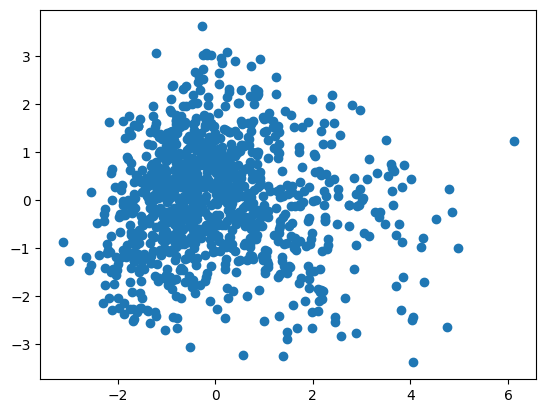

In [19]:
plt.scatter(x_new[:, 0], x_new[:, 1])

Явного разбиения при методе PCA не наблюдается. Посмотрим, что покажут другие методы

### TSNE

In [20]:
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(data_scaled)

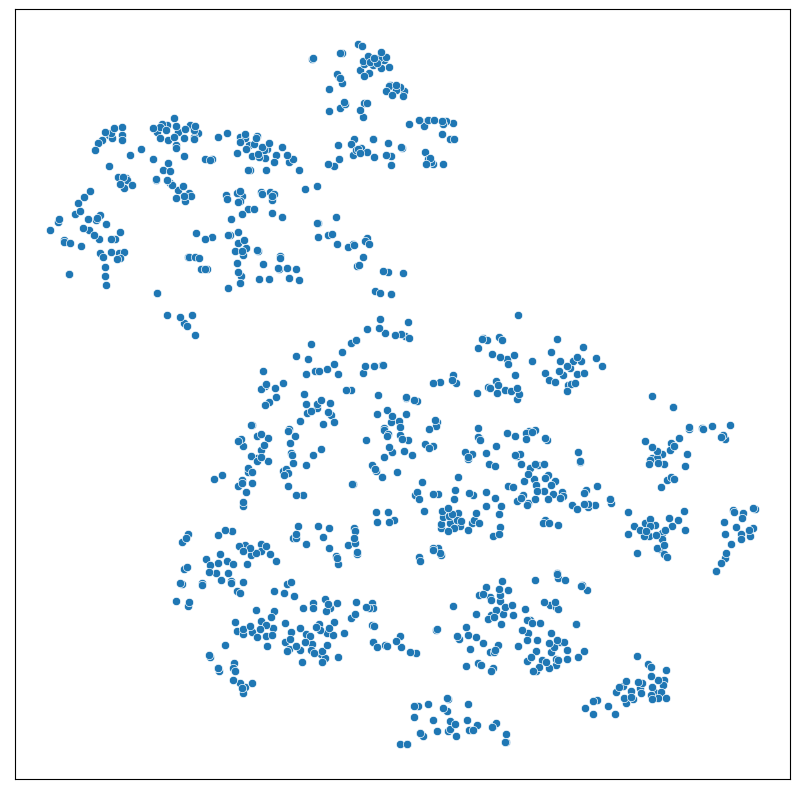

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0],
    y=tsne_transformed[:, 1],  
    palette="CMRmap",
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

### UMAP

In [22]:
import umap

In [23]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data_scaled)

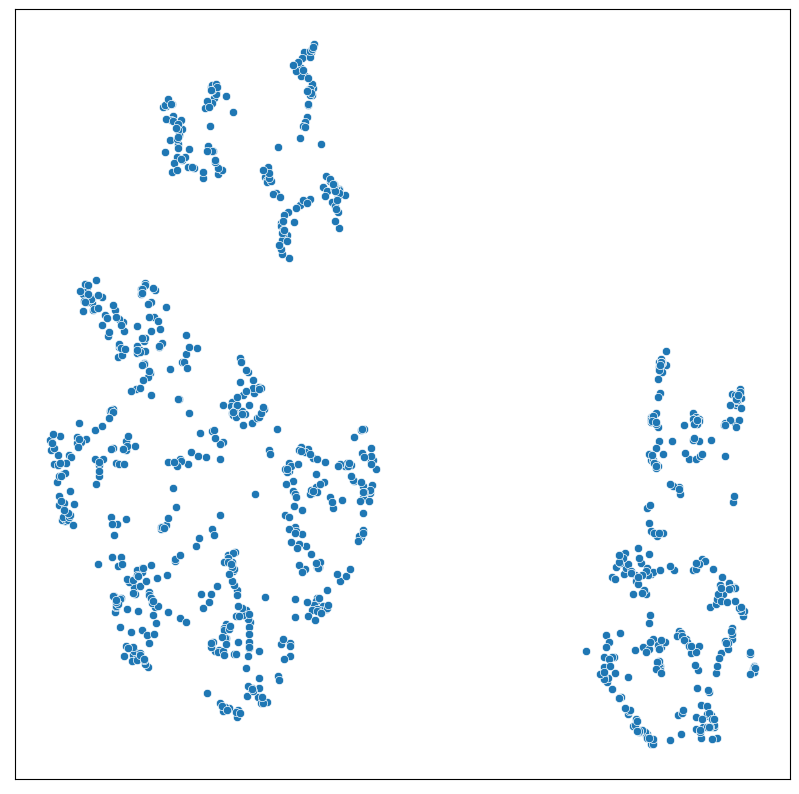

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    palette="CMRmap", 
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

Мы видим, что методы UMAP и TSNE лучше разделяют исходные данные на группы. Воспользуемся ими для дальнейшей визуализации

## 2.2 Кластеризация

## k-means

Метод k-means требует задания количества кластеров. Поэтому для начала мы рассчитаем его с помошью Elbow method. Посчитаем индекс инерции для kmeans с числом кластеров в диапазоне от 1 до 10.

In [25]:
k_max = 10

inertia = []
for k in range(1, k_max):

    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    
    inertia.append(np.sqrt(kmeans.inertia_))

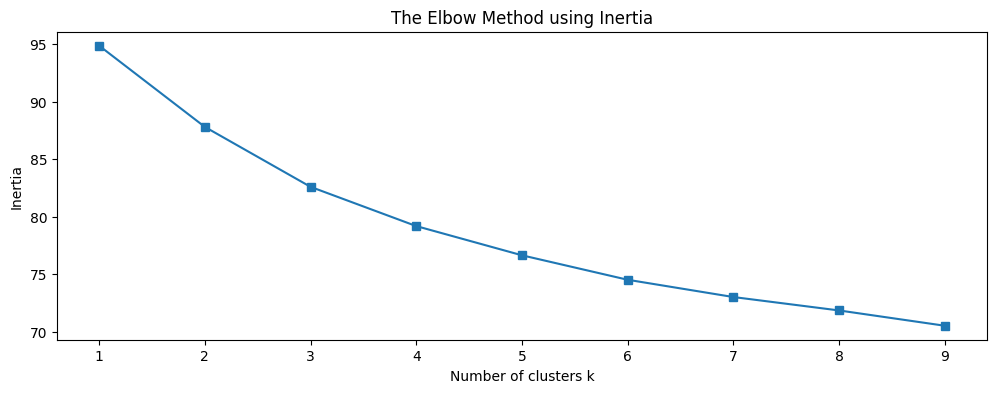

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

На графике нет ярко выраженных точек, начиная с которых график стал бы более линейным. Рассчитаем относительное изменение инерции

In [27]:
d = {}
for k in range(2, k_max-1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

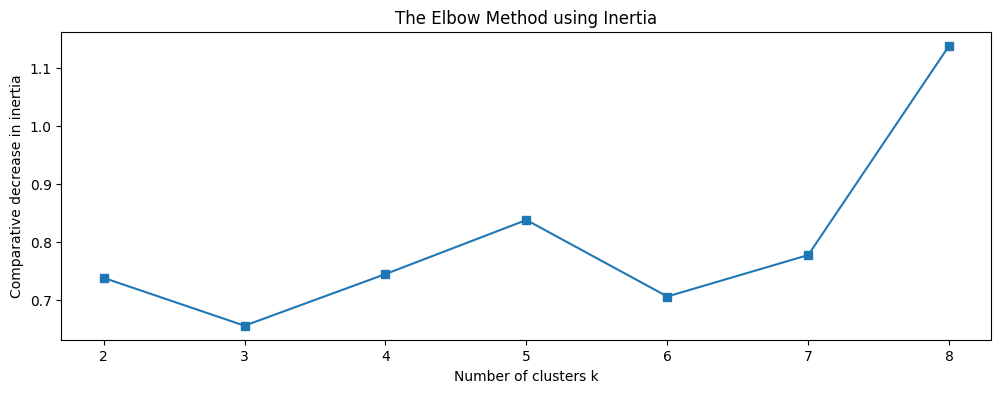

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max-1), [x for x in d.values()], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

Мы видим, что наилучшие значения получаются при количествах кластеров, равных трем и шести. Визуализируем эти данные с помощью TSNE

In [84]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(tsne_transformed)

KMeans(n_clusters=3)

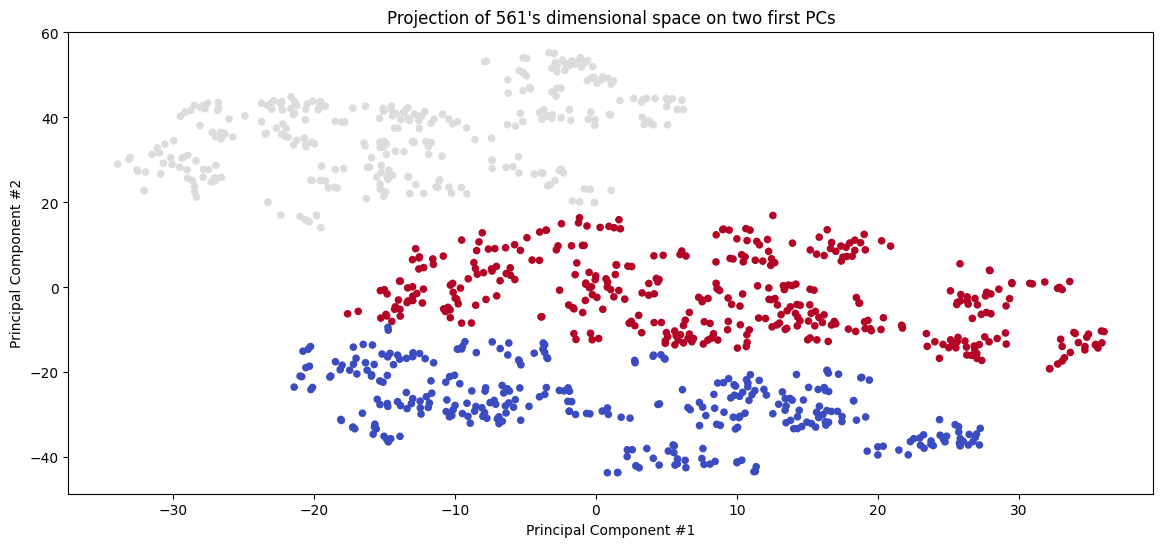

In [85]:
plt.figure(figsize=(14, 6))

plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

In [31]:
kmeans = KMeans(n_clusters=6)

kmeans.fit(tsne_transformed)

KMeans(n_clusters=6)

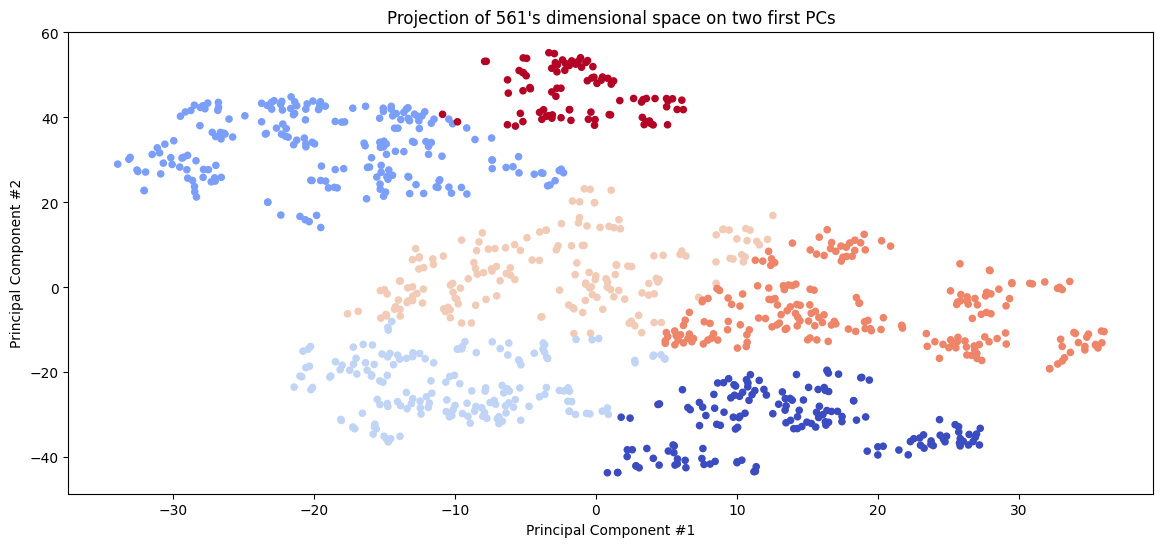

In [32]:
plt.figure(figsize=(14, 6))

plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

При разделении на 3 кластера алгоритм k-means справился достаточно хорошо. Посмотрим на более сложные алгоритмы

In [86]:
labels = kmeans.labels_

### Интерпретация

In [87]:
data_kmeans = data.copy()
data_kmeans['labels'] = labels
data_kmeans['labels'].value_counts(normalize=True)

2    0.378
0    0.319
1    0.303
Name: labels, dtype: float64

In [88]:
data_kmeans.groupby('labels').median()[['Age', 'Credit amount', 'Duration']]

,Age,Credit amount,Duration
labels,,,
0,34.0,2096.0,18.0
1,28.0,1924.0,18.0
2,36.0,3114.0,22.5


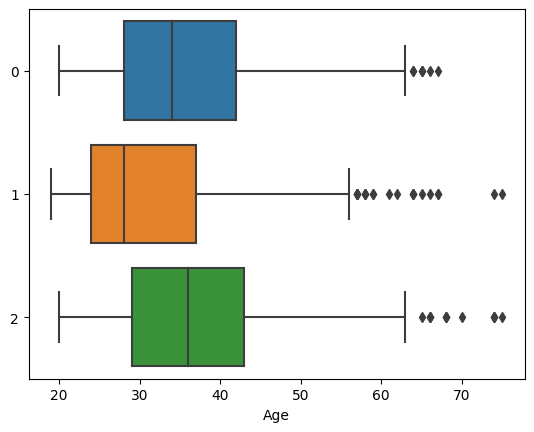

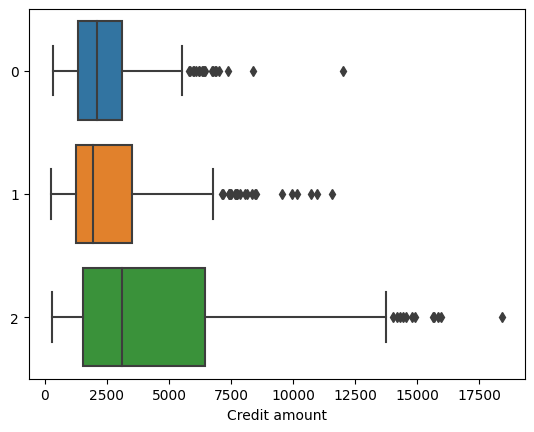

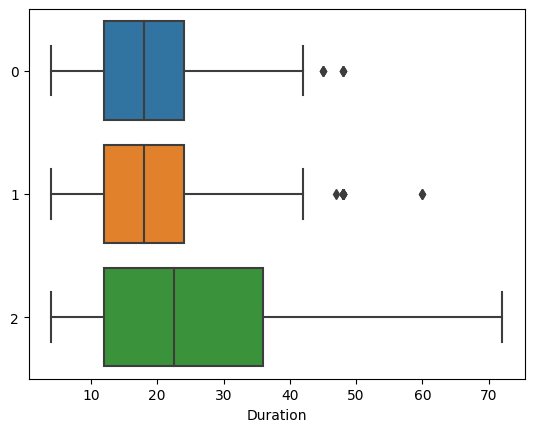

In [89]:
for col in ['Age', 'Credit amount', 'Duration']:
    sns.boxplot(data=data_kmeans, x=col, y=labels, orient='h')
    plt.show();

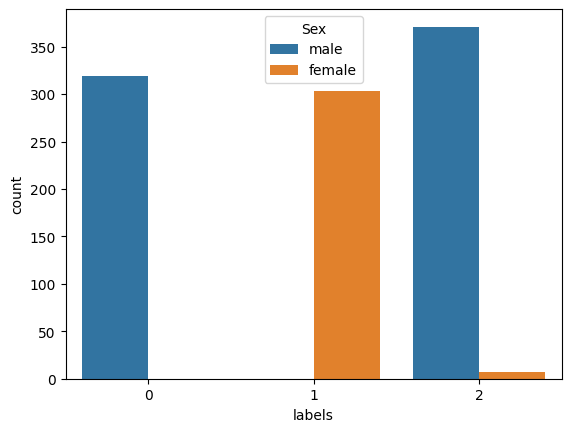

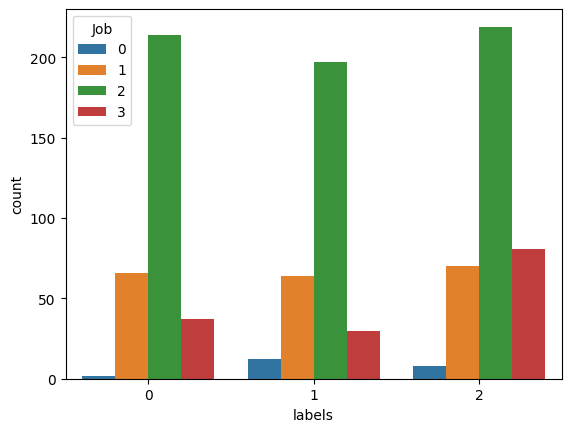

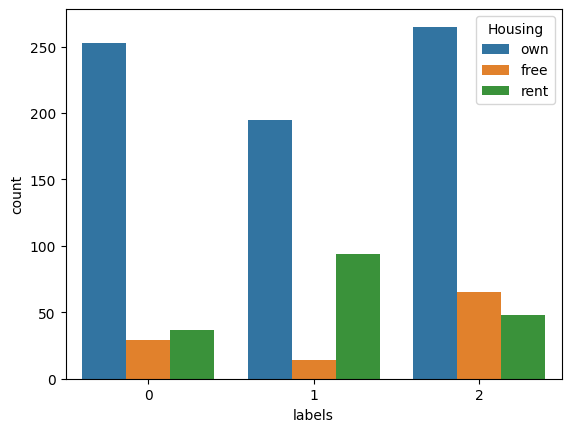

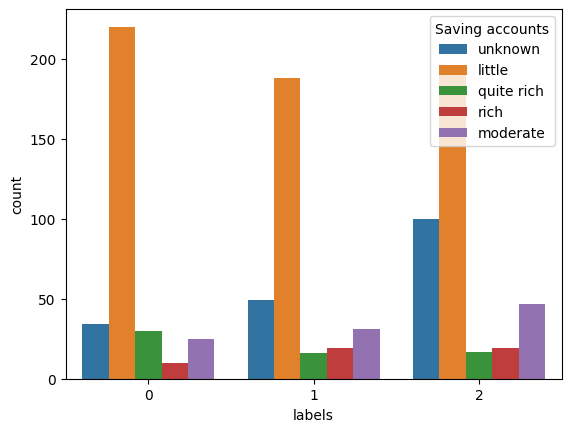

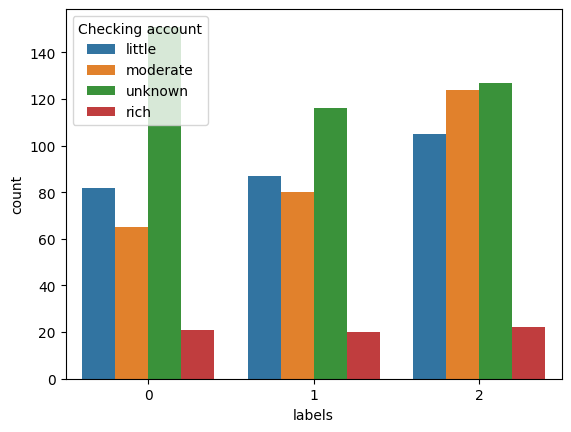

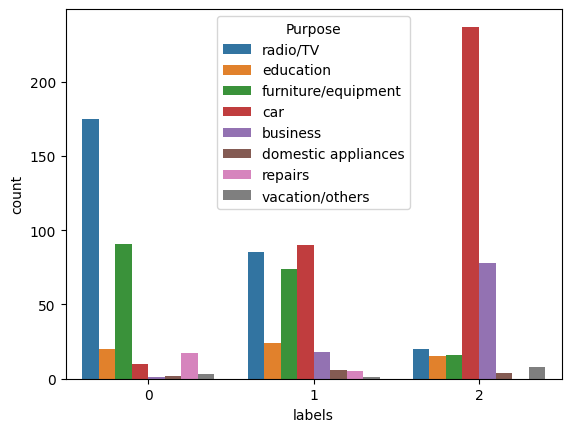

In [90]:
for col in ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']:
    sns.countplot(data=data_kmeans, x="labels", hue=col)
    plt.show()

Из полученных результатов видно, что основным признаком, на основании которого kmeans провел разделения на кластеры являются пол и цель кредита. В 0 кластер вошли мужчины со средним возрастом 34 года, сроком кредита на 18 месяцев и медианной суммой кредита 2096.0 DM. Основной целью кредита в этом кластере является радио/тв, на втором месте приобретение мебели/техники. К первому кластеру алгоритм отнес женщин с медианным возрастом 28 лет и суммой кредита 1924.0 на 18 месяцев. Доминирующие цели в данной группе примерно равным образом распределились между покупкой мебели/техники, радио/тв и покупкой машины. Во втором кластере наибольшее количество клиентов обратились в банк с целью покупки машины, на втором месте идет вложение в бизнес. Средний срок и сумма кредита здесь чуть выше, чем в первых двух кластерах - 22.5 и 3114.0 соответственно.

### Hierarhical (AgglomerativeClustering)

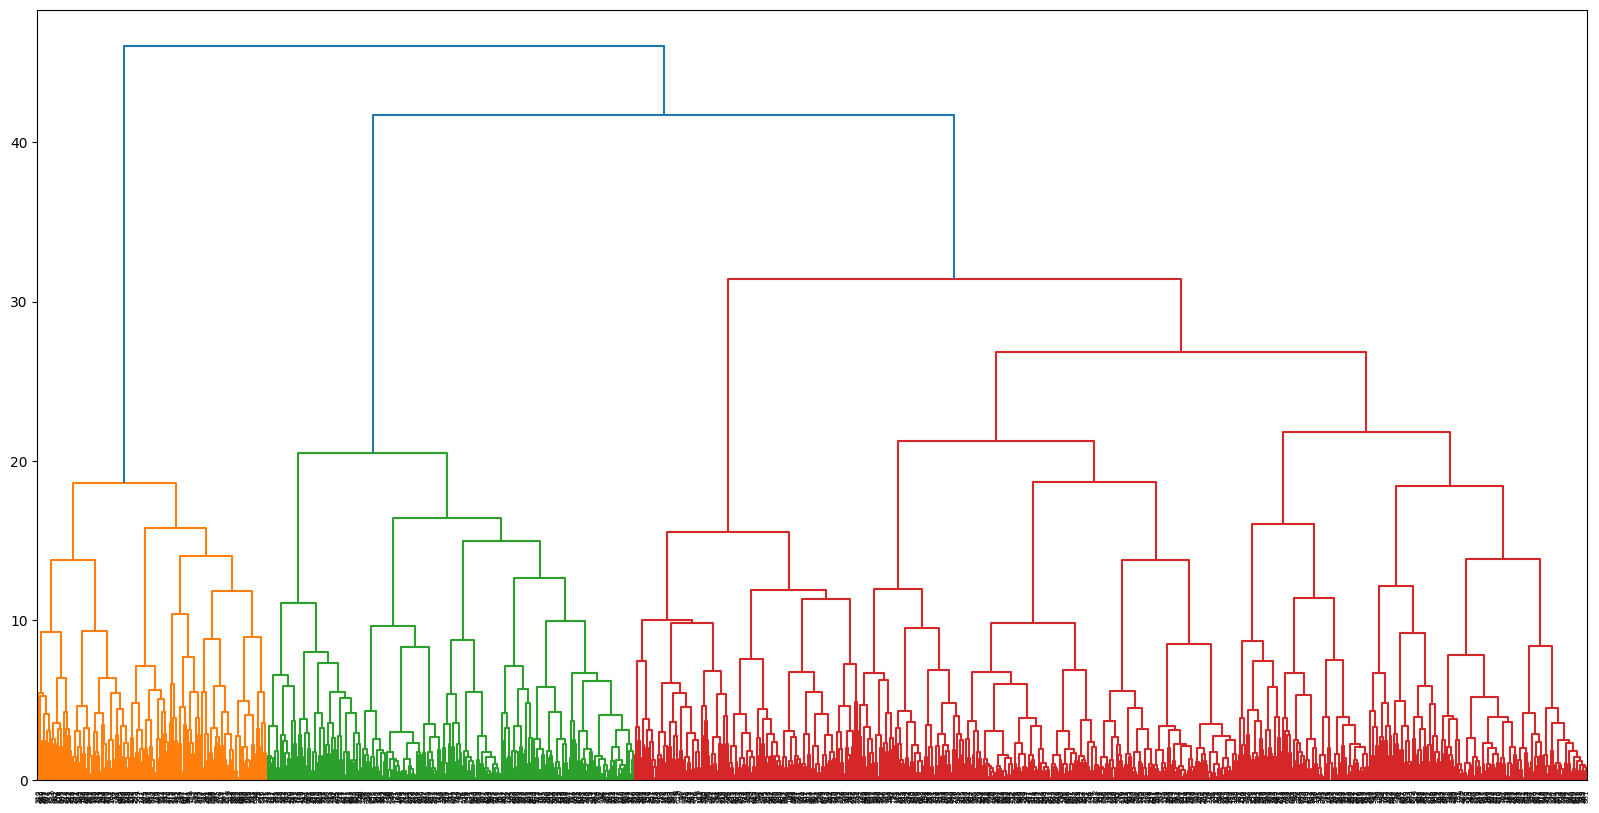

In [33]:
plt.figure(figsize=(20,10))
linkage_ = linkage(data_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

На полученной дендрограмме мы можем видеть, что наши данные можно разбить на три крупных кластера. Рассчитаем для данного метода коэффициент "Силуэта"

Для начала посмотрим как выглядят наши графики при разбиении на 3 и 5 кластеров с использованием TSNE и UMAP

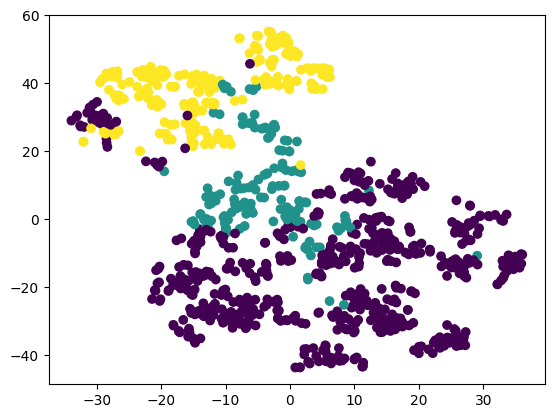

In [34]:
agg = AgglomerativeClustering(n_clusters=3).fit(data_scaled)
labels = agg.labels_

plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=labels);

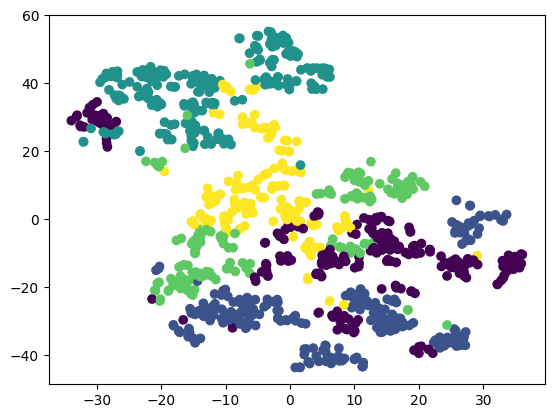

In [35]:
agg = AgglomerativeClustering(n_clusters=5).fit(data_scaled)
labels = agg.labels_

plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=labels);

И с использованием UMAP:

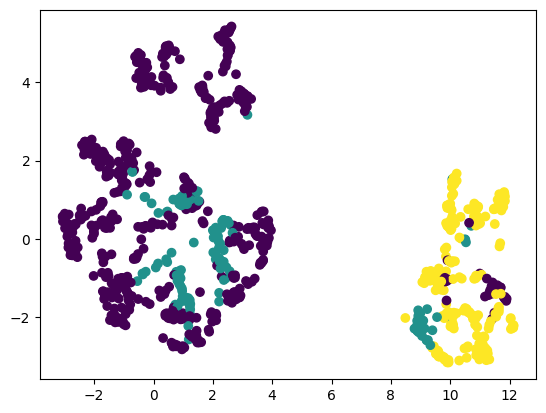

In [36]:
agg = AgglomerativeClustering(n_clusters=3).fit(data_scaled)
labels = agg.labels_

plt.scatter(embedding[:,0], embedding[:,1], c=labels);

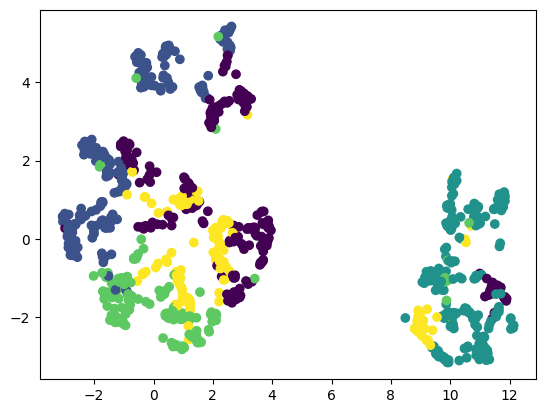

In [37]:
agg = AgglomerativeClustering(n_clusters=5).fit(data_scaled)
labels = agg.labels_

plt.scatter(embedding[:,0], embedding[:,1], c=labels);

Посчитаем коэффициент "Силуэта" для определения числа кластеров

In [38]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(data_scaled)
    labels = agg.labels_
    score = silhouette_score(data_scaled, labels)
    silhouette.append(score)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 14.07it/s]


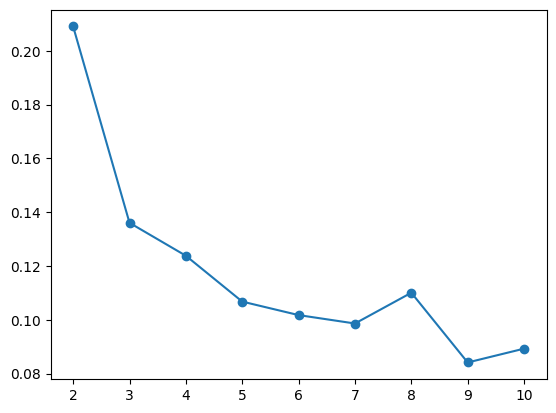

In [39]:
plt.plot(range(2,11), silhouette, marker='o');

Мы видим, что максимальное значение при количестве кластеров, равном двум. Попробуем взять значение linkage = 'single'

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 16.72it/s]


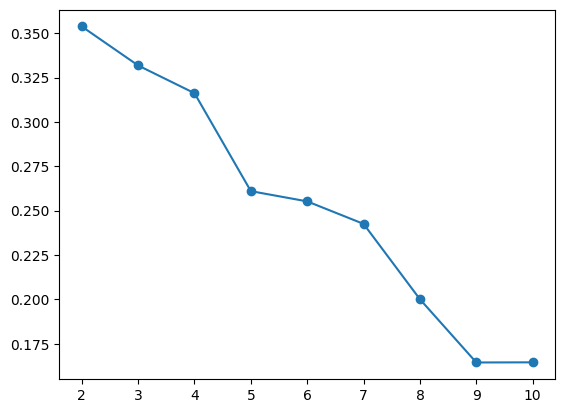

In [43]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i, linkage = 'single').fit(data_scaled)
    labels = agg.labels_
    score = silhouette_score(data_scaled, labels)
    silhouette.append(score)
plt.plot(range(2,11), silhouette, marker='o');

В этом случае также наилучшее качество при количество кластеров равном двум. Визуализируем получившиеся данные

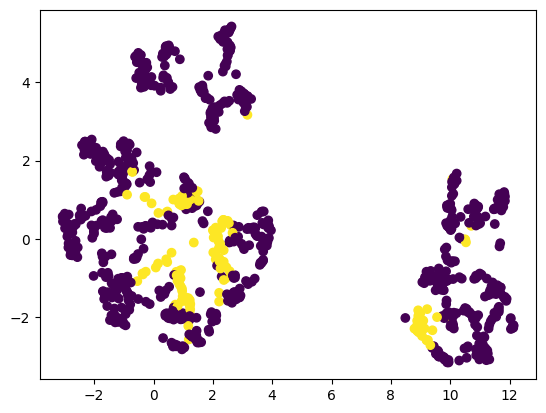

In [46]:
agg = AgglomerativeClustering(n_clusters=2).fit(data_scaled)
labels = agg.labels_

plt.scatter(embedding[:,0], embedding[:,1], c=labels);

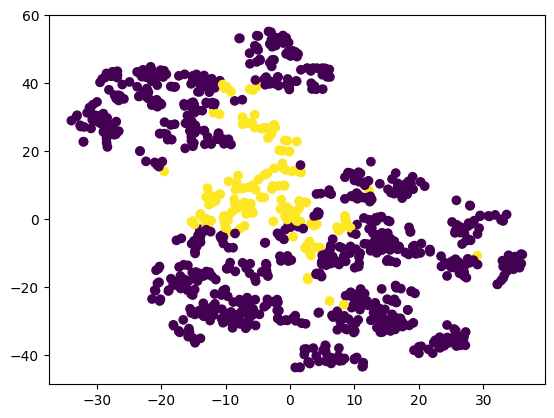

In [49]:
plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=labels);

### Интерпретация

In [50]:
data_hierarhical = data.copy()
data_hierarhical['labels'] = labels
data_hierarhical['labels'].value_counts(normalize=True)

0    0.852
1    0.148
Name: labels, dtype: float64

85 % данных относятся к 0 кластеру. Посмотрим на медианные и средние значения для каждого кластера

In [51]:
data_hierarhical.groupby('labels').median()[['Age', 'Credit amount', 'Duration']]

,Age,Credit amount,Duration
labels,,,
0,33.0,1978.0,15.0
1,34.5,7533.5,36.0


In [52]:
data_hierarhical.groupby('labels').mean()[['Age', 'Credit amount', 'Duration']]

,Age,Credit amount,Duration
labels,,,
0,35.518779,2435.132629,17.616197
1,35.702703,8084.628378,39.824324


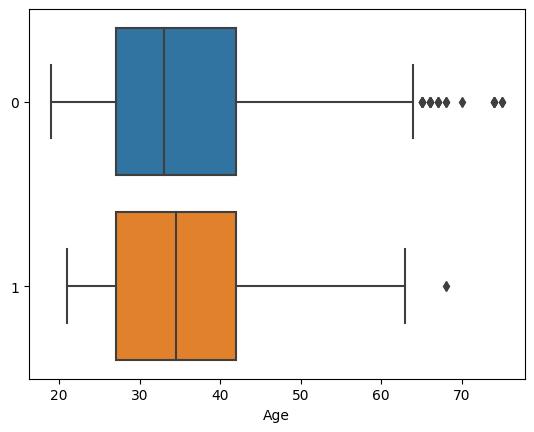

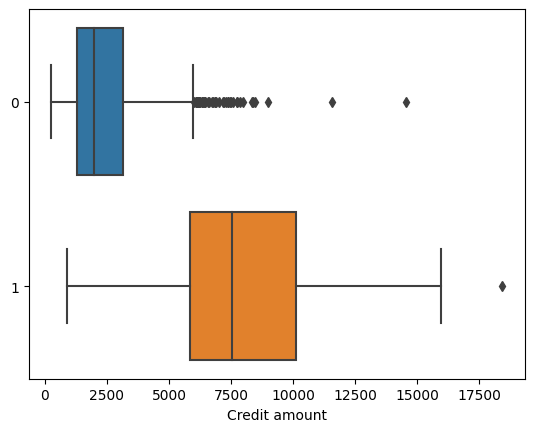

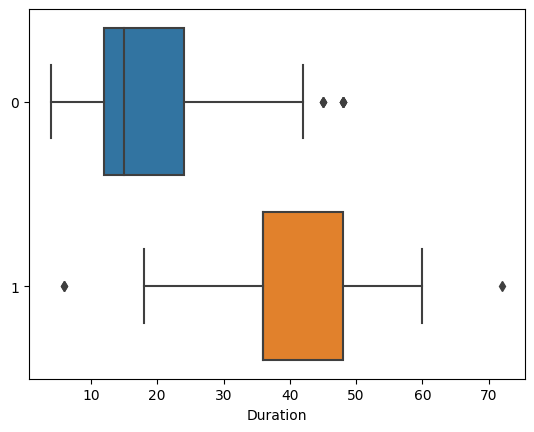

In [53]:
for col in ['Age', 'Credit amount', 'Duration']:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

Средний возраст у получившихся кластеров приблизительно одинаковый. Основное различе, на основании которого алгоритм разделил кластеры - срок и сумма кредита (из таблицы корреляций мы видили, что это сильно коррелирующие величины). Посмотрим на категориальные признаки

In [56]:
data_hierarhical.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'labels'],
      dtype='object')

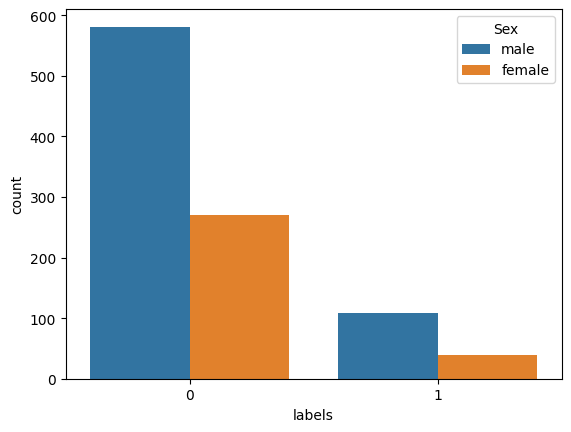

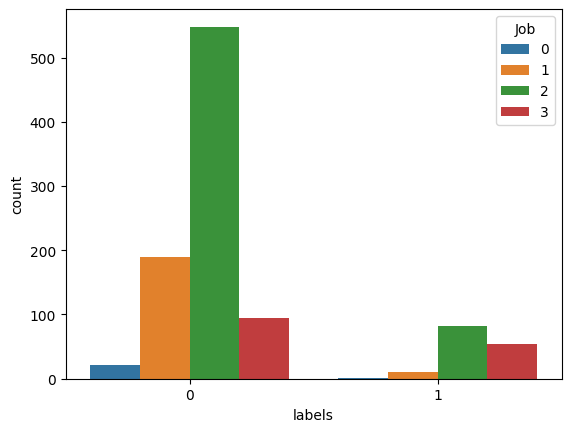

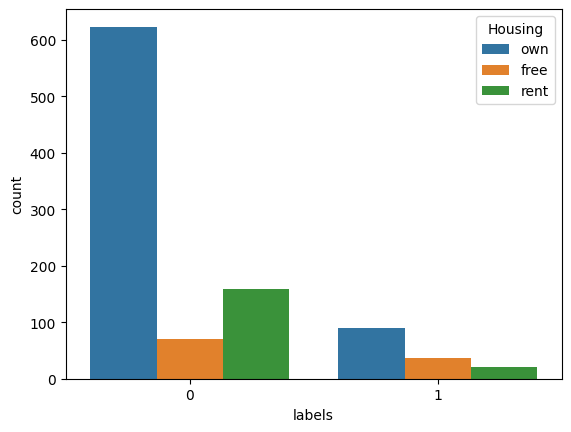

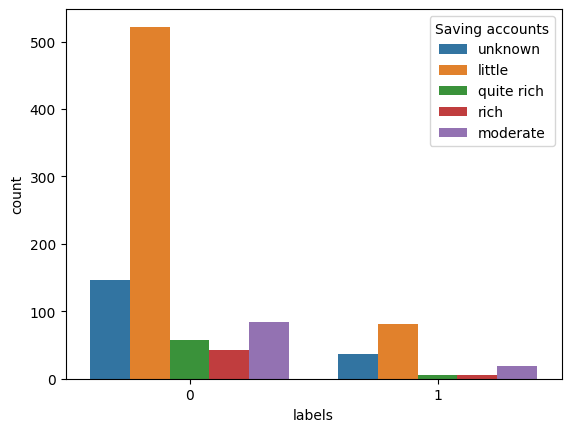

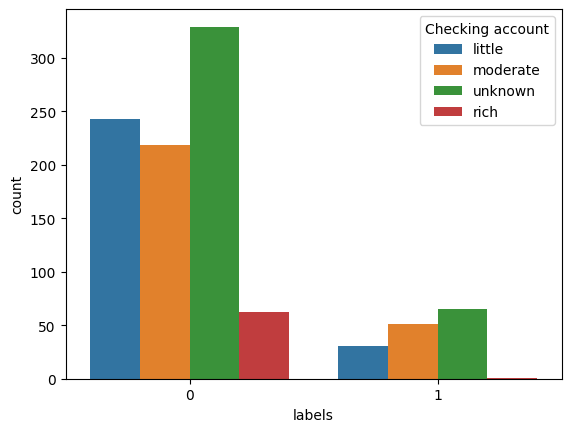

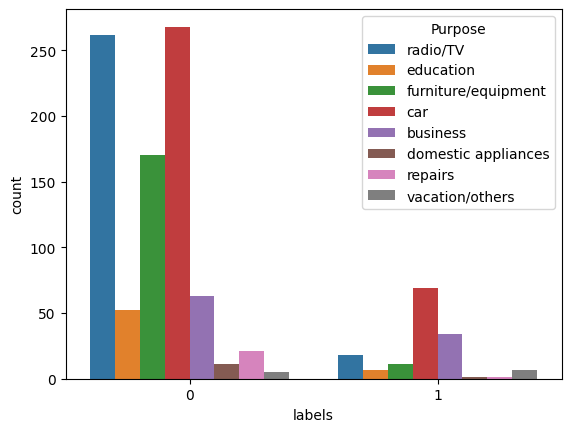

In [59]:
for col in ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']:
    sns.countplot(data=data_hierarhical, x="labels", hue=col)
    plt.show()

In [ ]:
sns.countplot(data=data, x="labels", hue="Purpose")

Из полученных графиков видно, что для 0 кластера, в котором сумма и срок кредита ниже, наиболее популярные цели кредита radio/TV и машины приблизительно в равной степени, в то время как для 1 кластера с большей суммой кредита машина я вляется наиболле частой целью с большим отставанием от остальных категорий. По состоянию текущего счета в 0 кластере слегка преобладает низкий уровень, в 1 кластере больше клиентов с умеренным уровнем счета, однако по обоим кластерам у большей части состояние текущего счета неизвестно. Что касается сберегательного счета, то для 0 кластера с большим отрывом выделяется низкий уровень, в то время как для первого данные более равномерны. Данные по полу приблизительно одинаковы в обоих кластерах.

### DBSCAN

Воспользуемся функцией для выбора оптимального размера радиуса окрестности eps 

In [60]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|██████████████████████████████████████████| 78/78 [00:06<00:00, 12.83it/s]


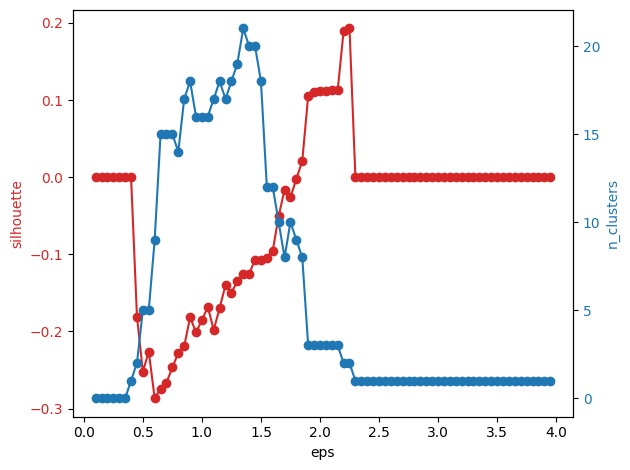

In [61]:
eps_range = np.arange(0.1,4,0.05)
dbscan_clustering(eps_range, data_scaled)

Мы видим, что наибольшее значение силуэта при количестве кластеров, равном трем и при эпсилон, равном 2.15 

In [68]:
dbscan = DBSCAN(eps=2.15).fit(data_scaled)
labels = dbscan.labels_

визуализируем получившиеся данные, воспользовавшись методом снижения размерности UMAP

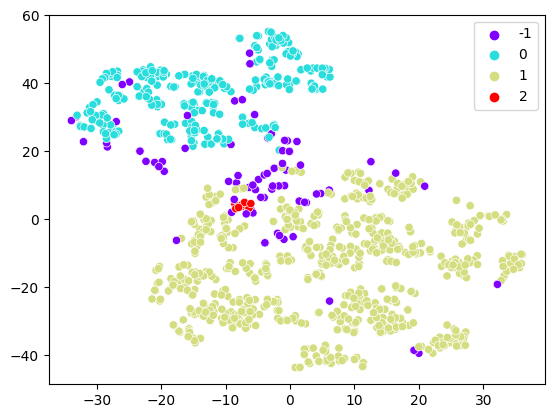

In [69]:
sns.scatterplot(x=tsne_transformed[:,0], y=tsne_transformed[:,1], hue=labels, palette='rainbow');

### Интерпретация 

In [70]:
data['labels'] = labels
data['labels'].value_counts(normalize=True)

 1    0.639
 0    0.272
-1    0.081
 2    0.008
Name: labels, dtype: float64

Для начала посмотрим на медианные и средние значения численных признаков

In [72]:
data.groupby('labels').median()[['Age', 'Credit amount', 'Duration']]

,Age,Credit amount,Duration
labels,,,
-1,41.0,7408.0,27.0
0,28.0,1812.5,16.5
1,35.0,2333.0,18.0
2,37.5,9166.0,42.0


In [74]:
data.groupby('labels').mean()[['Age', 'Credit amount', 'Duration']]

,Age,Credit amount,Duration
labels,,,
-1,44.320988,7663.320988,32.234568
0,31.169118,2402.161765,18.132353
1,36.251956,3010.563380,20.381847
2,39.125000,9173.875000,42.000000


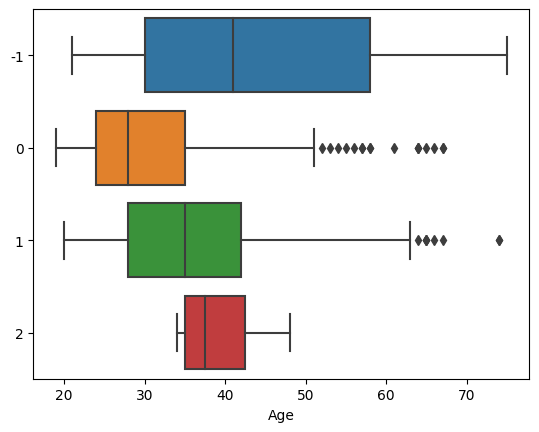

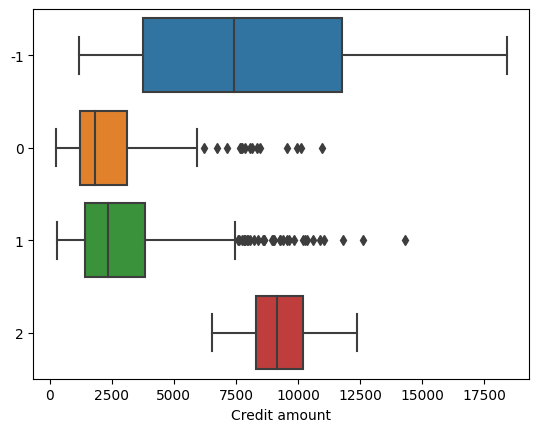

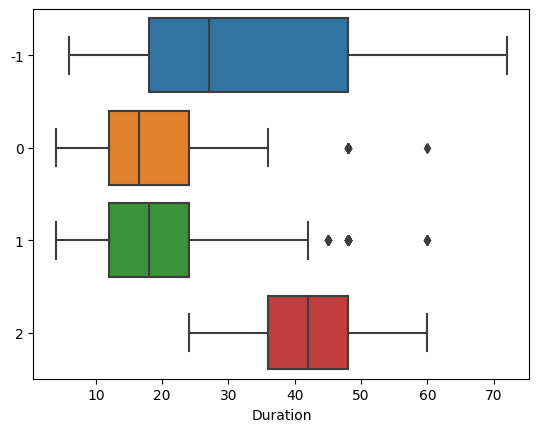

In [75]:
for col in ['Age', 'Credit amount', 'Duration']:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

По сравнению с иерархической кластеризацией, DBSCAN разделил кластеры с учетом возраста. Наибольшее количество клиентов (64%), отнесенных к первому кластеру имеют средний возраст 36 и берут кредит на срок в среднем 20 месяцев и сумму 3010 DM. На втором месте по количеству клиентов 0 кластер, в нем средний возраст составляет 31 год, срок кредита 18 месяцев и сумма 2402 DM. Наиболее малочисленный класс это люди в возрасте в среднем 39 лет, берущие кредит на длительный срок (42 месяца) и на большую сумму (средняя сумма 9173 DM)

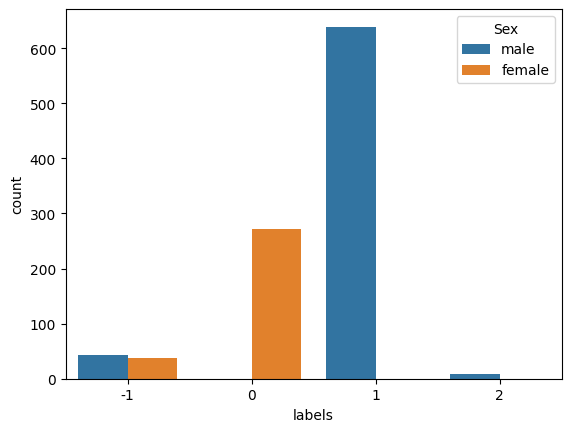

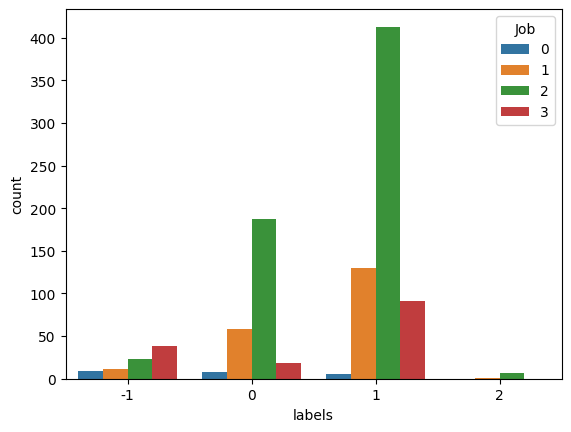

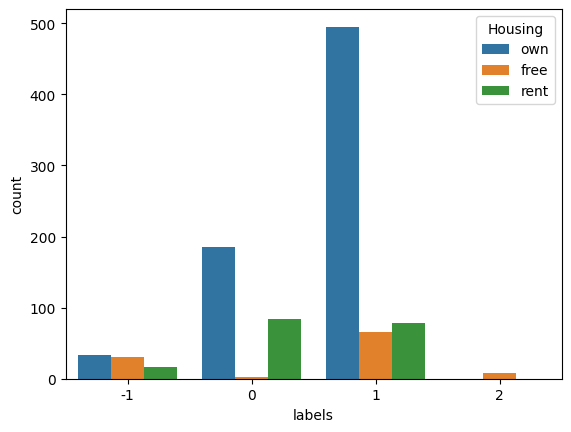

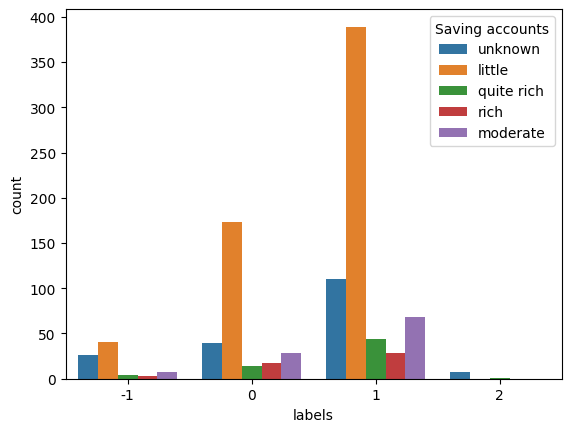

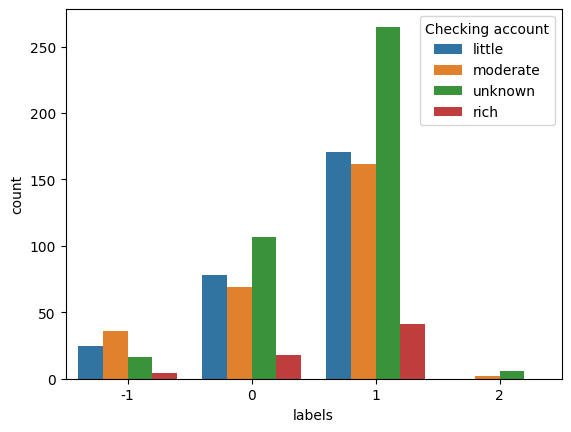

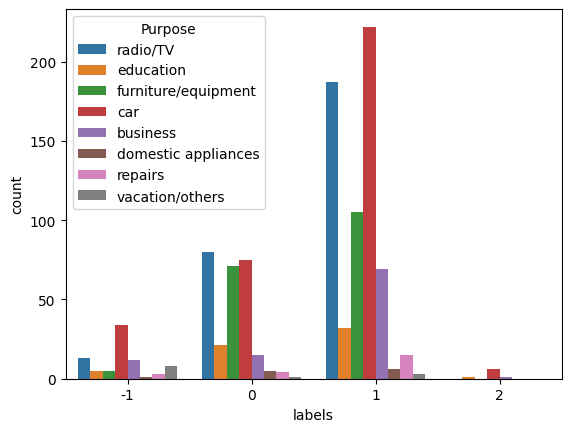

In [76]:
for col in ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']:
    sns.countplot(data=data, x="labels", hue=col)
    plt.show()

Из полученных графиков видно, что в 0 кластер вошли только щенщины, в 1 и 2 только мужчины. Наиболее отличительной чертой полувшихся кластеров является цель кредита. В 1 кластере явным образом преобладают радио/ТВ и машины, в то время как в 0 кластере примерно одинаково распределены радио/ТВ, машины, мебель/техника. Также в 1 кластере достаточно большое количество клиентов берут кредит для бизнеса, в то время как в 0 больше целей для обучения. Во втором кластере доминирующей целью является приобретение автомобиля. Для всех кластеров состояние текущих счетов распределено примерно в равной степени. Также можно выделить, что у нулевого и первого класса уровень сберегательного счета у большей части клиентов низкий, тогда как для второго характерен средний уровень. Что касается жилья, то к нулевому классу практически не относятся клиенты без жилья, тогда как в первом отсутствие жилья и аренда распределены примерно в равной степени.

## Вывод
В ходе проведения исследования было рассмотрено три вида кластеризации K-means, hierarhical и DBSCAN  с различными подходами к подбору количества кластеров и методами снижения размерности. Алгоритмы K-means и DBSCAN провели разбиение на кластеры в большей степени с учетом пола и целей кредита, разбив клиентов на 3 кластера. Hierarhical показал наилучшее качество при разбиении на два кластера в зависимости от суммы и продолжительности кредита.